# Using Transformer - Sequences with ATG

In this notebook, we will train a transformer model on the sequences with ATG to predict the mean ribosome load.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['agg.path.chunksize'] = 0
mpl.rcParams.update( mpl.rc_params() )
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': 'bold'})
plt.rc('font', family='serif')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import r2_score

import json

## Useful Functions

In [18]:
def split_atg(X1,X,y):
    label_atg,atg,label_no_atg,no_atg = [], [], [], []
    for i in range(len(X)):
        seq = ""
        for j in range(len(X[i])-1):
            seq += X[i][j][0]
        seq += X[i][-1]
        if "ATG" in seq:
            atg.append(X1[i])
            label_atg.append(y[i])
        else:
            no_atg.append(X1[i])
            label_no_atg.append(y[i])
    return np.array(label_atg),np.array(atg),np.array(label_no_atg),np.array(no_atg) 
    

def split_seq_into_words(n, seqs):
    return np.array([" ".join([str(seqs[i][j:j+n]) for j in range(0,len(seqs[i])-n+1)]) for i in range(len(seqs))])
    

def r2(x,y):
    return 1 - sum((x-y)**2)/sum((x-np.mean(x))**2)
            
    

## Splitting the data into Traning, Validation and Test Sets

In [19]:
data_path = "Data/GSM3130435_egfp_unmod_1_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')


In [20]:
df.head()

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r9,r10,r11,r12,r13,rl,Selection,one-hot encoding,Length,scaled_rl
0,120605,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,0.000137,0.000109,0.000057,0.000033,0.000015,0.000016,0.000009,0.000009,...,0.019283,0.033252,0.033252,0.027581,0.035877,3.039939,Selected Data,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",50,-2.130922
1,11605,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,0.000067,0.000070,0.000065,0.000048,0.000023,0.000020,0.000011,0.000011,...,0.024241,0.039457,0.039457,0.039840,0.038785,3.895109,Selected Data,"[[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",50,-1.600332
2,128224,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,0.000088,0.000081,0.000059,0.000035,0.000017,0.000016,0.000009,0.000009,...,0.021591,0.028353,0.028353,0.028963,0.041985,3.334524,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.948147
3,239107,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,0.000078,0.000071,0.000060,0.000038,0.000025,0.000016,0.000010,0.000009,...,0.026617,0.038302,0.038302,0.032788,0.031043,3.575082,Selected Data,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.798893
4,59082,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,0.000044,0.000045,0.000050,0.000051,0.000033,0.000026,0.000015,0.000012,...,0.033080,0.051449,0.051449,0.046052,0.036447,4.593712,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...",50,-1.166885


In [21]:
rl = df["scaled_rl"].values
utr = df["utr"].values

In [22]:
label_utr_atg,utr_atg,label_utr_no_atg,utr_no_atg = split_atg(utr, utr, rl)

In [23]:
utr = utr_atg
scaled_rl = label_utr_atg

In [24]:
sentences = split_seq_into_words(5, utr)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(sentences, scaled_rl, test_size=0.2, random_state=25)
X_val, X_test1, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)

## Tokenization and Encoding

In [26]:
max_len = (len(sentences[0])+1)//6
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  1025


In [11]:
token_string = tokenizer.to_json()
with open("atg_token2.json", "w") as file:
    json.dump(token_string, file)

In [27]:
train_temp = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_temp = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_temp = tokenizer.texts_to_sequences(X_test1)
X_test = pad_sequences(test_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Building and training the model

In [3]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.forward = Sequential([layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),])
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)
        self.layernormalization1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernormalization2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, training):
        att_out = self.attention(inputs, inputs)
        att_out = self.dropout1(att_out, training=training)
        output1 = self.layernormalization1(inputs + att_out)
        fwd_output = self.forward(output1)
        fwd_output = self.dropout2(fwd_output, training=training)
        return self.layernormalization2(output1 + fwd_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_embedding = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        pos = tf.range(start=0, limit=maxlen, delta=1)
        pos = self.pos_embedding(pos)
        x = self.token_embedding(x)
        return x + pos

In [29]:
embed_dim = 50
heads = 20
neurons = 32
units=46

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(max_len,))(x)
x = layers.Dense(46, activation="relu")(x)
outputs = layers.Dense(1, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)

In [30]:
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[r2_score], run_eagerly=True)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 46)]              0         
                                                                 
 token_and_position_embeddin  (None, 46, 50)           53550     
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_1 (Tran  (None, 46, 50)           206532    
 sformerEncoder)                                                 
                                                                 
 rnn_1 (RNN)                 (None, 46)                17848     
                                                                 
 dense_6 (Dense)             (None, 46)                2162      
                                                           

In [16]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [17]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=20,
                    batch_size=128)

Epoch 1/20
945/945 [==============================] - 763s 806ms/step - loss: 0.6373 - r2_score: 0.3127 - val_loss: 0.4062 - val_r2_score: 0.5213
Epoch 2/20
945/945 [==============================] - 759s 803ms/step - loss: 0.3368 - r2_score: 0.6351 - val_loss: 0.3015 - val_r2_score: 0.6435
Epoch 3/20
945/945 [==============================] - 762s 806ms/step - loss: 0.2608 - r2_score: 0.7169 - val_loss: 0.2095 - val_r2_score: 0.7550
Epoch 4/20
945/945 [==============================] - 767s 812ms/step - loss: 0.1920 - r2_score: 0.7916 - val_loss: 0.1704 - val_r2_score: 0.8016
Epoch 5/20
945/945 [==============================] - 764s 808ms/step - loss: 0.1631 - r2_score: 0.8228 - val_loss: 0.1524 - val_r2_score: 0.8244
Epoch 6/20
945/945 [==============================] - 772s 817ms/step - loss: 0.1438 - r2_score: 0.8442 - val_loss: 0.1380 - val_r2_score: 0.8387
Epoch 7/20
945/945 [==============================] - 768s 813ms/step - loss: 0.1322 - r2_score: 0.8564 - val_loss: 0.1292 -

In [18]:
#model.save('model_trans1')
model.save('model_transformer_mrl_fit_atg2')

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_atg2\assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_atg2\assets


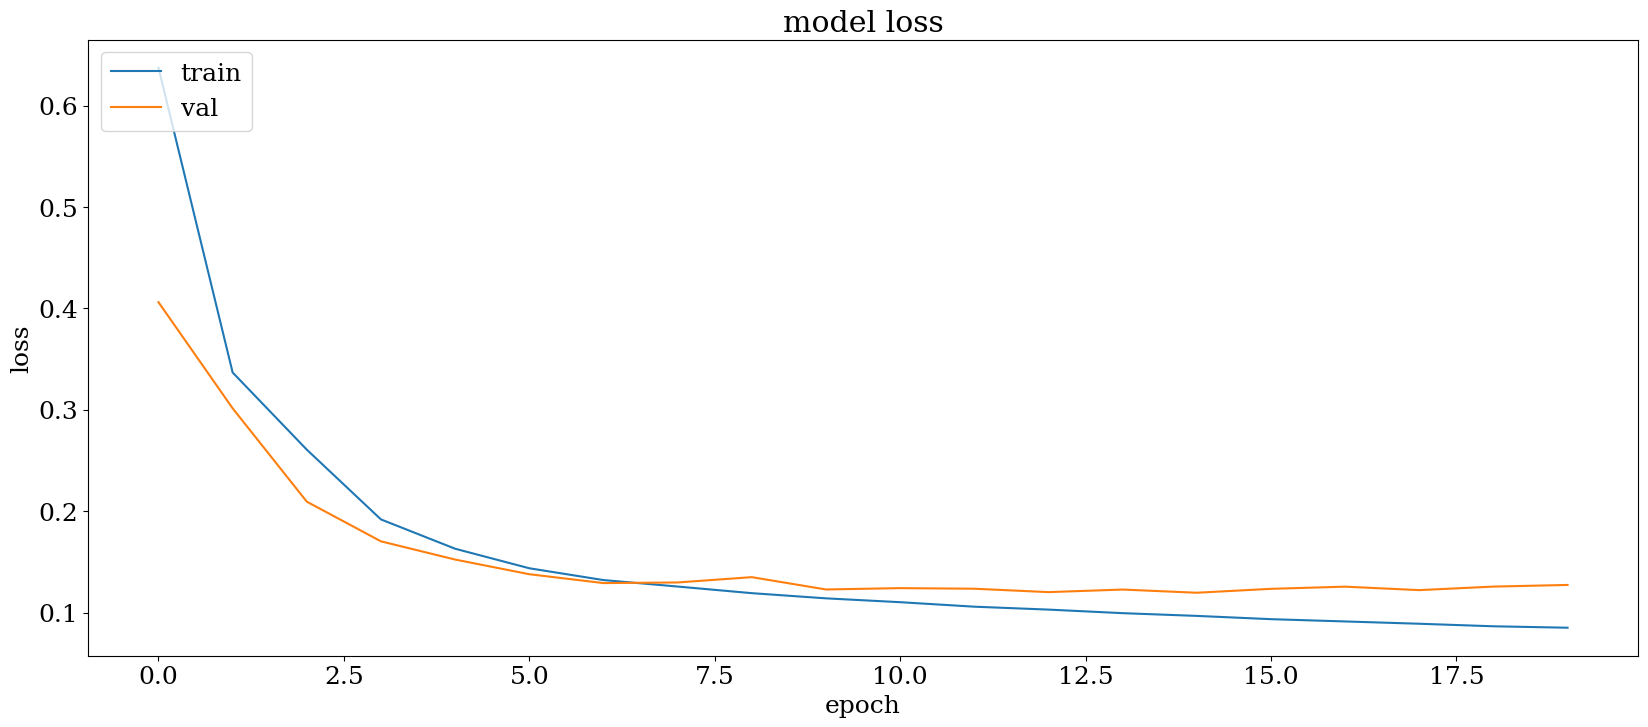

In [19]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the model

In [20]:
#model = keras.models.load_model('model_trans1')

In [21]:
y_test = y_test.reshape(-1)

In [22]:
predictions = model.predict(X_test).reshape(-1)
r2(y_test, predictions)

473/473 [==============================] - 64s 136ms/step


0.8527806849381505

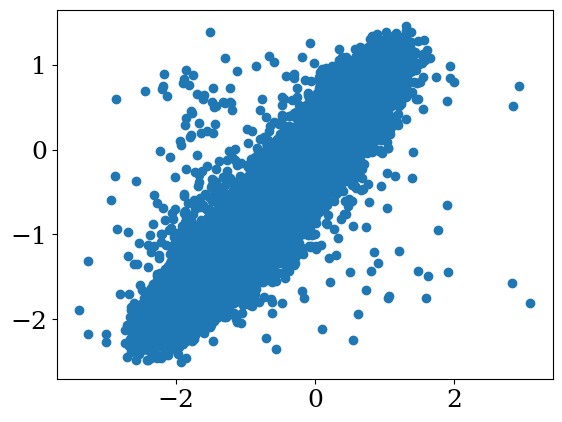

In [23]:
plt.scatter(y_test.reshape(-1), predictions)
plt.show()

In [24]:
np.savez("Test_atg2.npz",X_test = X_test, y_test=y_test)